# Sex Associated Contigs

Upon looking at prevalence of different bacteria, we noticed there were two contigs that had a very clear bimodal distribution: "BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|: Fusobacterium ulcerans ATCC 49185", and "BACT_769|gi|223714005|gb|ACDT01000210.1|: Mollicutes bacterium D7 cont1.210".
 

Looking into this distribution further, it is perfectly split between males/females. Here is additional analysis on coverage, heritability, and confounding variables.

Slides are at:

https://docs.google.com/presentation/d/1OywBpRkitcj3MtNcaSDGfRueEOew217uYOZkhohLx_g/edit?usp=sharing

In [1]:
import pandas as pd
from collections import Counter
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import glob
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import glm

BLOOD_MICROBIOME_DIR = '/home/groups/dpwall/briannac/blood_microbiome/'
bam_mappings_file = '/home/groups/dpwall/briannac/general_data/bam_mappings.csv'
fig_dir = BLOOD_MICROBIOME_DIR + 'results/sex_associated_contigs/'

In [4]:
bacteria_file = BLOOD_MICROBIOME_DIR + 'data/bacteria_agg_strain.csv' 

In [2]:
bam_mappings = pd.read_csv(bam_mappings_file, sep='\t')
bam_mappings.index = bam_mappings.sample_id

In [7]:
## Test
df_bacteria = pd.read_csv(bacteria_file, index_col=0)
#[bam_mappings[i.split(' -')[0]] for i in bacteria_abundance_df.index]

In [8]:
sexes = [bam_mappings.loc[i.split(' -')[0]].sex_numeric for i in df_bacteria.index]
df_bacteria['sex'] = sexes

In [9]:
fuso_mollicutes_count = df_bacteria[['Fusobacterium ulcerans', 'Mollicutes bacterium D7']]
fuso_mollicutes_count.index = [i.split(' ')[0] for i in fuso_mollicutes_count.index]
fuso_mollicutes_count.columns = ['fusobacterium', 'mollicutes']

# Build table of fuso & mollicutes counts.

In [11]:
fuso_mollicutes_count['sample'] = fuso_mollicutes_count.index
fuso_mollicutes_count['sex'] = bam_mappings.loc[fuso_mollicutes_count.index].sex_numeric
fuso_mollicutes_count['relationship'] = bam_mappings.loc[fuso_mollicutes_count.index].relationship
fuso_mollicutes_count['family'] = bam_mappings.loc[fuso_mollicutes_count.index].family
fuso_mollicutes_count['pheno'] = [str(b) for b in bam_mappings.loc[fuso_mollicutes_count.index].derived_affected_status]
fuso_mollicutes_count['batch'] = bam_mappings.loc[fuso_mollicutes_count.index].sequencing_plate
fuso_mollicutes_count['celltype'] = bam_mappings.loc[fuso_mollicutes_count.index].bio_seq_source
fuso_mollicutes_count

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

,fusobacterium,mollicutes,sample,sex,relationship,family,pheno,batch,celltype
02C10540,178697,147918,02C10540,1.0,father,AU1005,nan,MTR-00927,LCL
02C10541,545,471,02C10541,2.0,mother,AU1005,nan,MTR-00927,LCL
02C10542,259,146,02C10542,2.0,sibling,AU1005,broad-spectrum,MTR-00927,LCL
02C10543,201124,168995,02C10543,1.0,sibling,AU1005,autism,MTR-00927,LCL
02C10702,3,5,02C10702,2.0,mother,AU1004,nan,MTR-00010,LCL
...,...,...,...,...,...,...,...,...,...
MH0143008,205311,176311,MH0143008,1.0,father,AU3859,nan,MTR-00027,WB
MH0143009,83,23,MH0143009,2.0,mother,AU3859,nan,MTR-00027,WB
MH0143013,211029,183542,MH0143013,1.0,sibling,AU3859,nan,MTR-00027,WB
MH0143018,159181,99083,MH0143018,1.0,sibling,AU3859,autism,MTR-00027,WB


# Sex, batch, and cell type effects

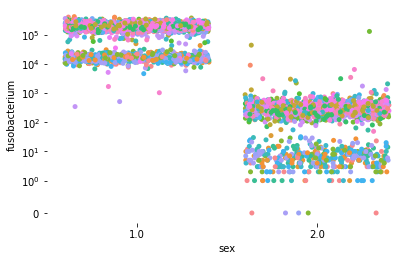

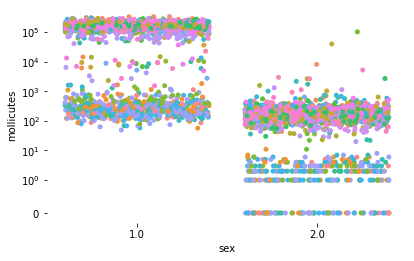

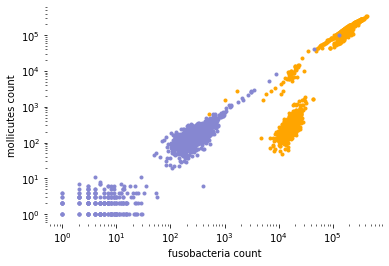

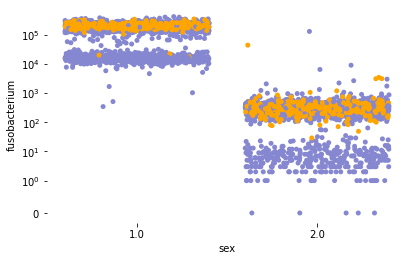

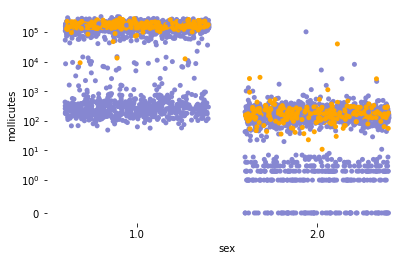

In [12]:
fig = plt.figure(figsize=(5,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_yscale("symlog", linthresh=1)
g=sns.stripplot(data=fuso_mollicutes_count, x='sex', y='fusobacterium', hue='batch', jitter=.4)# palette=['orange', '#8687d1'])
g.legend_.remove()
plt.box(on=False)
plt.savefig('%s/fuso_counts_colored_by_batch.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

fig = plt.figure(figsize=(5,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_yscale("symlog", linthresh=1)
g=sns.stripplot(data=fuso_mollicutes_count, x='sex', y='mollicutes', hue='batch', jitter=.4)# palette=['orange', '#8687d1'])
g.legend_.remove()
plt.box(on=False)
plt.savefig('%s/mollicutes_count_colored_by_batch.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()



plt.plot(fuso_mollicutes_count[fuso_mollicutes_count.sex=='1.0'].fusobacterium.values, fuso_mollicutes_count[fuso_mollicutes_count.sex=='1.0'].mollicutes.values,
         '.',color='orange', label='male')
plt.plot(fuso_mollicutes_count[fuso_mollicutes_count.sex=='2.0'].fusobacterium.values, fuso_mollicutes_count[fuso_mollicutes_count.sex=='2.0'].mollicutes.values, 
         '.',color='#8687d1', label='female')
plt.xlabel('fusobacteria count')
plt.ylabel('mollicutes count')
plt.legend().remove()
plt.box(on=False)
plt.yscale('log')
plt.xscale('log')
plt.savefig('%s/mollicutes_fuso_count.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()


fig = plt.figure(figsize=(5,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_yscale("symlog", linthresh=1)
g=sns.stripplot(data=fuso_mollicutes_count, x='sex', y='fusobacterium', hue='celltype',palette=['#8687d1','orange'], jitter=.4)
g.legend_.remove()
plt.box(on=False)
plt.savefig('%s/fuso_counts_colored_by_celltype.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

fig = plt.figure(figsize=(5,3)) 
rect = 0,0,1,1 
log_ax = fig.add_axes(rect)
log_ax.set_yscale("symlog", linthresh=1)
g=sns.stripplot(data=fuso_mollicutes_count, x='sex', y='mollicutes', hue='celltype', palette=['#8687d1', 'orange'], jitter=.4)
g.legend_.remove()
plt.box(on=False)
plt.savefig('%s/mollicutes_counts_colored_by_celltype.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()



In [13]:
import statsmodels.api as sm
from statsmodels.formula.api import glm

lm=glm('fusobacterium ~ mollicutes + C(batch)', data=fuso_mollicutes_count, family=sm.families.Poisson()).fit() #Specify C for Categorical
print(lm.pvalues['mollicutes'])

lm=glm('mollicutes ~ fusobacterium + C(batch)', data=fuso_mollicutes_count, family=sm.families.Poisson()).fit()
print(lm.pvalues['fusobacterium'])

0.0
0.0


***Hypothesis: this batch effect is due to higher concentrations of restriction enzymes / shearing chemicals, making it more likely the sequence gets chopped too small*** 

# Family Transmissibility

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


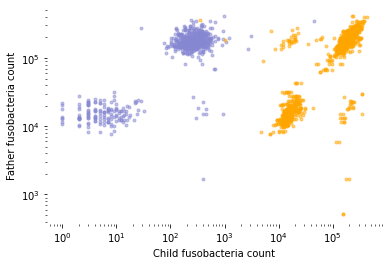

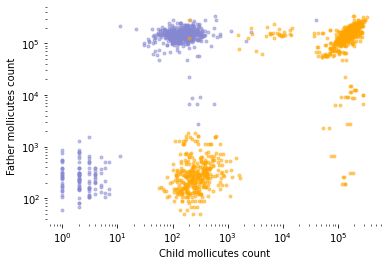

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


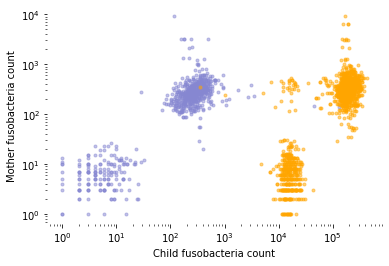

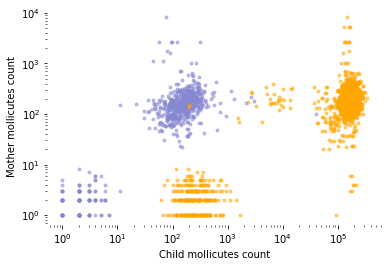

In [14]:
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>-1]

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
kids_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling')]
family_idx = set(fathers_all.family.values).intersection(set(kids_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
kids = kids_all[[f in family_idx for f in kids_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[kids.family.values]
kids['parent_fuso'] = fathers['fusobacterium'].values
kids['parent_mollicutes'] = fathers['mollicutes'].values

plt.plot(kids[kids.sex=='2.0'].fusobacterium.values, kids[kids.sex=='2.0'].parent_fuso.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].fusobacterium.values, kids[kids.sex=='1.0'].parent_fuso.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child fusobacteria count')
plt.ylabel('Father fusobacteria count')
plt.box(on=False)
plt.savefig('%s/fusobacteria_child_father.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()

plt.plot(kids[kids.sex=='2.0'].mollicutes.values, kids[kids.sex=='2.0'].parent_mollicutes.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].mollicutes.values, kids[kids.sex=='1.0'].parent_mollicutes.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child mollicutes count')
plt.ylabel('Father mollicutes count')
plt.box(on=False)
plt.savefig('%s/mollicutes_child_father.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()


fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>-1]
mothers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='mother']
kids_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling')]
family_idx = set(mothers_all.family.values).intersection(set(kids_all.family.values))
_, idx = np.unique(mothers_all.family, return_index=True)
mothers = mothers_all.iloc[idx]
mothers = mothers[[f in family_idx for f in mothers.family]]
kids = kids_all[[f in family_idx for f in kids_all.family]]
mothers.index=mothers.family
mothers = mothers.loc[kids.family.values]
kids['parent_fuso'] = mothers['fusobacterium'].values
kids['parent_mollicutes'] = mothers['mollicutes'].values

plt.plot(kids[kids.sex=='2.0'].fusobacterium.values, kids[kids.sex=='2.0'].parent_fuso.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].fusobacterium.values, kids[kids.sex=='1.0'].parent_fuso.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child fusobacteria count')
plt.ylabel('Mother fusobacteria count')
plt.box(on=False)
plt.savefig('%s/fusobacteria_child_mother.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()


plt.plot(kids[kids.sex=='2.0'].mollicutes.values, kids[kids.sex=='2.0'].parent_mollicutes.values, '.', color='#8687d1', label='female', alpha=.5)
plt.plot(kids[kids.sex=='1.0'].mollicutes.values, kids[kids.sex=='1.0'].parent_mollicutes.values, '.', color='orange', label='male', alpha=.5)
plt.legend().remove()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Child mollicutes count')
plt.ylabel('Mother mollicutes count')
plt.box(on=False)
plt.savefig('%s/mollicutes_child_mother.png' % fig_dir, transparent=True, bbox_inches='tight', format='png', dpi=500)
plt.show()



In [15]:
mothers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='mother']
kids_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling')]
family_idx = set(mothers_all.family.values).intersection(set(kids_all.family.values))
_, idx = np.unique(mothers_all.family, return_index=True)
mothers = mothers_all.iloc[idx]
mothers = mothers[[f in family_idx for f in mothers.family]]
kids = kids_all[[f in family_idx for f in kids_all.family]]
mothers.index=mothers.family
mothers = mothers.loc[kids.family.values]
kids['parent_fuso'] = mothers['fusobacterium'].values
kids['parent_mollicutes'] = mothers['mollicutes'].values

/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


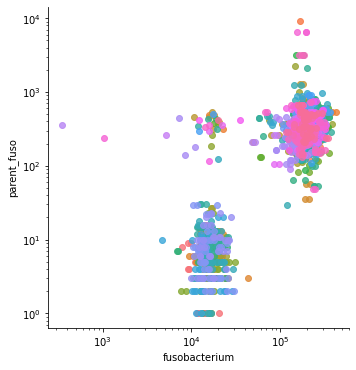

In [16]:
g=sns.lmplot(data=kids[kids.sex=='1.0'], x='fusobacterium', y='parent_fuso', hue='batch', fit_reg=False)
g._legend.remove()
plt.xscale('log')
plt.yscale('log')

# Which are correlated?

In [17]:
print('Father/son high cluster')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>10000]
fuso_mollicutes_count_high.fusobacterium = (fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = (fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='1.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('fusobacterium ~ parent_fuso + C(batch)', data=sons,  family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_fuso'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])



#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Father/son high cluster
0.0
0.0


/home/users/briannac/.local/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [18]:
print('Father/son low cluster')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes<10000]
fuso_mollicutes_count_high.fusobacterium = (fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = (fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='1.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('fusobacterium ~ parent_fuso + C(batch)', data=sons,  family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_fuso'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])



#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Father/son low cluster
0.0
8.648006348590198e-26


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
print('Father/daughter')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>15]
fuso_mollicutes_count_high.fusobacterium = np.log10(fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = np.log10(fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='2.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])



#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Father/daughter
0.961219355077991
0.961219355077991


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
print('Mother/daughter')
fuso_mollicutes_count_high = fuso_mollicutes_count[fuso_mollicutes_count.mollicutes>15]
fuso_mollicutes_count_high.fusobacterium = np.log10(fuso_mollicutes_count_high.fusobacterium)
fuso_mollicutes_count_high.mollicutes = np.log10(fuso_mollicutes_count_high.mollicutes)

fathers_all = fuso_mollicutes_count_high[fuso_mollicutes_count_high.relationship=='father']
sons_all = fuso_mollicutes_count_high[(fuso_mollicutes_count_high.relationship=='sibling') & 
                            (fuso_mollicutes_count_high.sex=='1.0')]
family_idx = set(fathers_all.family.values).intersection(set(sons_all.family.values))
_, idx = np.unique(fathers_all.family, return_index=True)
fathers = fathers_all.iloc[idx]
fathers = fathers[[f in family_idx for f in fathers.family]]
sons = sons_all[[f in family_idx for f in sons_all.family]]
fathers.index=fathers.family
fathers = fathers.loc[sons.family.values]

sons['parent_fuso'] = fathers['fusobacterium'].values
sons['parent_mollicutes'] = fathers['mollicutes'].values

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])

lm=glm('mollicutes ~ parent_mollicutes + C(batch)', data=sons, family=sm.families.Poisson()).fit()
print(lm.pvalues['parent_mollicutes'])


#plt.plot(sons.fusobacterium.values, fathers.fusobacterium.values, '.')


Mother/daughter
0.7262293269084039
0.7262293269084039


/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/users/briannac/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Correlated
- father/son mollicutes (in the high cluster) 
- father/son fusobacterium (in the high cluster)
- father /son fusobacterium (in the low cluster)

### Not correlated
- father/son mollicutes (in the low cluster)
- mother/* *
- father/daughter * 




# Correlation to Phenotype

In [160]:
sons = fuso_mollicutes_count[(fuso_mollicutes_count.relationship=='sibling') & 
                            (fuso_mollicutes_count.sex=='1.0')]
daughters = fuso_mollicutes_count[(fuso_mollicutes_count.relationship=='sibling') & 
                            (fuso_mollicutes_count.sex=='2.0')]

In [161]:
daughters
cont_female  = pd.crosstab(daughters['fusobacterium']>100, 
                            daughters['pheno'],  
                               margins = False)[['autism', 'nan']]

chi2, p, dof, ex = stats.chi2_contingency(cont_female)
print(cont_female)
print(p)
cont_male  = pd.crosstab(sons['fusobacterium']>100000, 
                            sons['pheno'],  
                               margins = False)[['autism', 'nan']]
chi2, p, dof, ex = stats.chi2_contingency(cont_male)
print(p)
print(cont_male)

pheno          autism  nan
fusobacterium             
False             126   61
True              291  172
0.3175121159794405
0.34330781794730836
pheno          autism  nan
fusobacterium             
False             345   47
True              953  156


**No correlation to phenotype.**

# Alignments

## Batch results
- 'Fusobacterium' contig aligns to: https://www.ncbi.nlm.nih.gov/nucleotide/AP023649.1?report=genbank&log$=nuclalign&blast_rank=1&RID=TPSYXJXC013
- No alignment for 'Mollicutes'

Both contigs are a little over 1kb.

In [ ]:
male_low = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_00009/02C11465/02C11465.final_alignment_table.csv')
female_low = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_00009/03C14334/03C14334.final_alignment_table.csv')
male_high = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_01019/08C74703/08C74703.final_alignment_table.csv')
female_high = pd.read_csv('/scratch/users/chloehe/unmapped_reads/bam/batch_01020/07C68441/07C68441.final_alignment_table.csv')


male_low


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


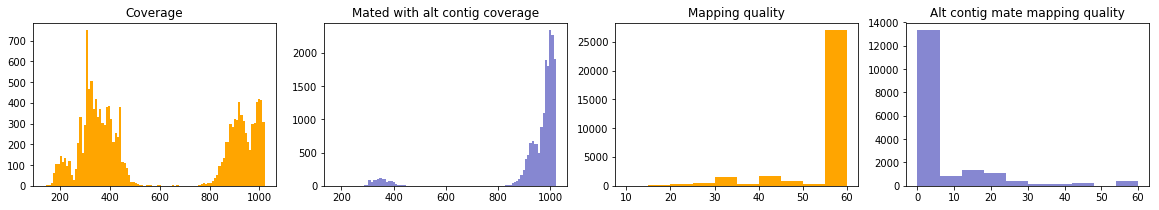

[('BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|', 14502), ('chr13', 9010), ('chrUn_JTFH01001465v1_decoy', 1991), ('chrUn_JTFH01001981v1_decoy', 1406), ('chr22', 1329), ('chr21', 1230), ('chr22_KI270731v1_random', 491), ('chrUn_JTFH01001669v1_decoy', 419), ('chrUn_JTFH01001405v1_decoy', 398), ('chr22_KI270734v1_random', 349)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


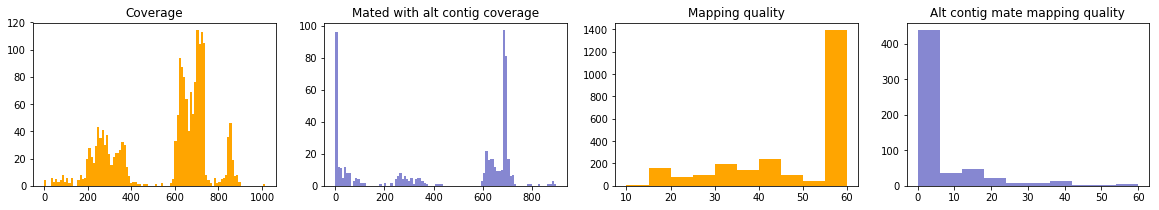

[('BACT_769|gi|223714005|gb|ACDT01000210.1|', 1860), ('chrUn_JTFH01001987v1_decoy', 105), ('chrUn_JTFH01001405v1_decoy', 83), ('chrUn_JTFH01001512v1_decoy', 75), ('chrUn_JTFH01001981v1_decoy', 55), ('chrUn_JTFH01000876v1_decoy', 54), ('chr21', 36), ('chrUn_JTFH01001506v1_decoy', 27), ('chrUn_JTFH01001553v1_decoy', 25), ('chrUn_JTFH01001669v1_decoy', 23)]
male_high


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


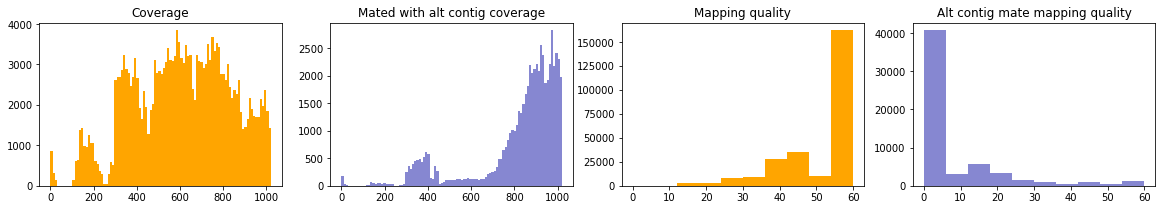

[('BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|', 200756), ('chr13', 19875), ('chrUn_JTFH01001465v1_decoy', 6354), ('chr22', 4870), ('chrUn_JTFH01001680v1_decoy', 4014), ('chr21', 3578), ('chrUn_JTFH01001981v1_decoy', 2957), ('chr22_KI270731v1_random', 1797), ('chrUn_JTFH01001677v1_decoy', 1648), ('chrUn_JTFH01001669v1_decoy', 1549)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


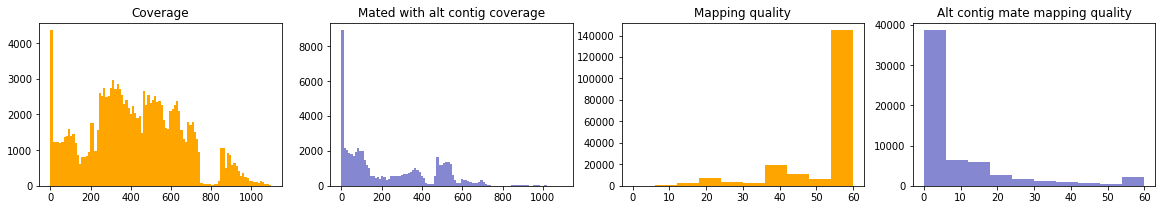

[('BACT_769|gi|223714005|gb|ACDT01000210.1|', 137894), ('chrUn_JTFH01001512v1_decoy', 14863), ('chrUn_JTFH01000876v1_decoy', 11357), ('chrUn_JTFH01001987v1_decoy', 4633), ('chr21', 4378), ('chr22', 3879), ('chrUn_JTFH01001669v1_decoy', 3168), ('chrUn_JTFH01001405v1_decoy', 2490), ('chr6', 1723), ('chr22_KI270734v1_random', 1587)]
female_low


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


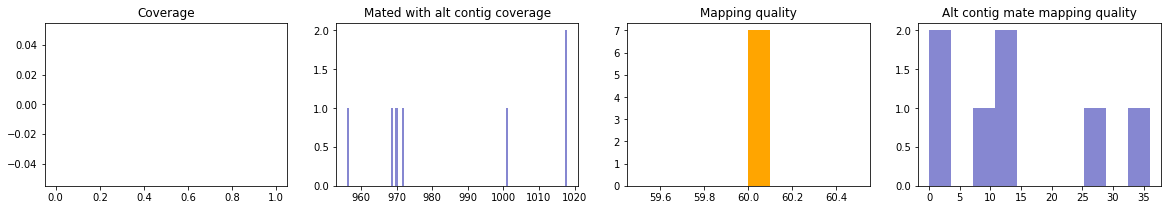

[('chrUn_JTFH01001465v1_decoy', 2), ('chrUn_JTFH01001405v1_decoy', 2), ('chr22', 1), ('chrUn_JTFH01001680v1_decoy', 1), ('chr13', 1)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


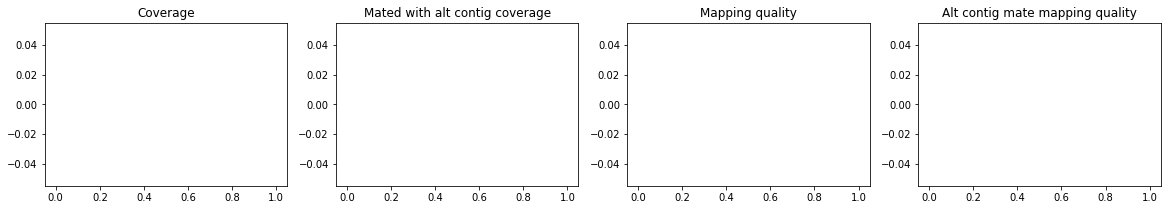

[]
female_high


 BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|


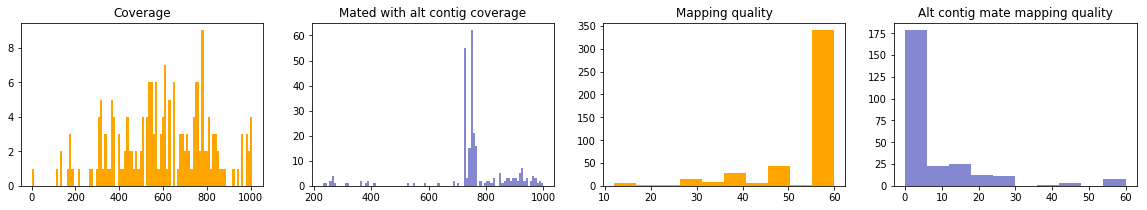

[('BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|', 190), ('chr22', 56), ('chr13', 40), ('chrUn_JTFH01001987v1_decoy', 37), ('chrUn_JTFH01001981v1_decoy', 28), ('chr10', 16), ('chrUn_JTFH01001465v1_decoy', 10), ('chr2', 9), ('chr1', 6), ('chrUn_JTFH01001677v1_decoy', 6)]


 BACT_769|gi|223714005|gb|ACDT01000210.1|


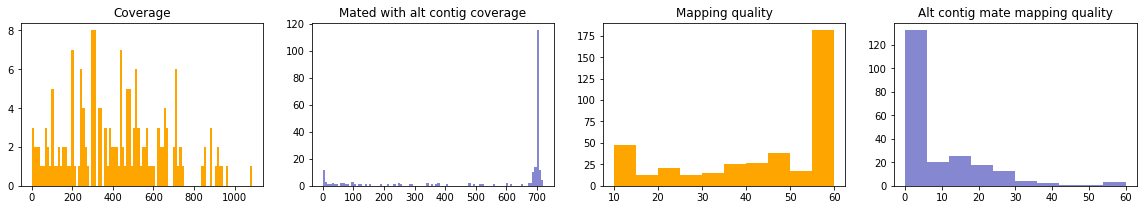

[('BACT_769|gi|223714005|gb|ACDT01000210.1|', 178), ('chrUn_JTFH01001987v1_decoy', 39), ('chr22', 23), ('chrUn_JTFH01001553v1_decoy', 15), ('chr6', 14), ('chrUn_JTFH01001512v1_decoy', 14), ('chrUn_JTFH01001981v1_decoy', 13), ('chrUn_JTFH01000876v1_decoy', 12), ('chr21', 10), ('chrUn_JTFH01001319v1_decoy', 10)]


In [182]:

fusobacterium_idx = 'BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|' 
mollicutes_idx = 'BACT_769|gi|223714005|gb|ACDT01000210.1|'

def AlignmentGraphs(table, idx):
    print('\n\n', idx)
    coverage = [
        int(i) for i in table[(table['R1_ref']==idx) & table.is_proper_pair].R1_start] + [
        int(i) for i in table[(table['R2_ref']==idx) & table.is_proper_pair].R2_start]
    improper_pair_coverage = [
        int(i) for i in table[(table['R1_ref']==idx) & (table['R2_ref']!=idx)].R1_start] + [
        int(i) for i in table[(table['R2_ref']==idx) &(table['R1_ref']!=idx)].R2_start]
    mapq = [
        int(i) for i in table[table['R1_ref']==idx].R1_MAPQ] + [
        int(i) for i in table[table['R2_ref']==idx].R2_MAPQ]
    pair_mapq = [
        int(i) for i in table[(table['R1_ref']==idx) & (table['R2_ref']!=idx)].R2_MAPQ if ~np.isnan(i)] + [
        int(i) for i in table[(table['R2_ref']==idx) & (table['R1_ref']!=idx)].R1_MAPQ if ~np.isnan(i)]
    pairs = list(
        table[table['R1_ref']==idx].R2_ref.values) +  list(
        table[table['R2_ref']==idx].R1_ref.values)

    f,ax = plt.subplots(1,4, figsize=(20,3))
    ax[0].hist(coverage, bins=100, color='orange')
    ax[0].set_title('Coverage')
    ax[1].hist(improper_pair_coverage, bins=100, color='#8687d1')
    ax[1].set_title('Mated with alt contig coverage')
    ax[2].hist(mapq, bins=10, color='orange')
    ax[2].set_title('Mapping quality')
    ax[3].hist(pair_mapq, bins=10, color='#8687d1')
    ax[3].set_title('Alt contig mate mapping quality')
    plt.show()
    print(Counter(pairs).most_common(10))

for title, example_table in zip(['male_low', 'male_high', 'female_low', 'female_high'], 
                                [male_low, male_high, female_low, female_high]):
    print(title)
    for idx in [fusobacterium_idx, mollicutes_idx]:
        AlignmentGraphs(example_table, idx)


## Reference Sequences

In [169]:
# Looking at sequences
bact_seqs = [r for r in SeqIO.parse('/scratch/groups/dpwall/personal/chloehe/unmapped_reads/ref_genome/combined.fa', 'fasta') if 
            ((r.id=='BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|') | (r.id=='BACT_769|gi|223714005|gb|ACDT01000210.1|'))]

In [37]:
count = Counter(np.concatenate([alignment['R1_ref'].values, alignment['R2_ref'].values]))

In [33]:
ids['BACT_769|gi|223714005|gb|ACDT01000210.1|']

'BACT_769|gi|223714005|gb|ACDT01000210.1| Mollicutes bacterium D7 cont1.210, whole genome shotgun sequence'

In [119]:
ids['BACT_577|gi|224473368|ref|NZ_ACDH01000101.1|']

'BACT_577|gi|224473368|ref|NZ_ACDH01000101.1| Fusobacterium ulcerans ATCC 49185 NZ_ACDH01000101, whole genome shotgun sequence'